# Определение возраста покупателей

# Исследовательский анализ данных

Данные взяты с сайта ChaLearn Looking at People.

В вашем распоряжении еще CSV-файл labels.csv с двумя колонками: file_name и real_age.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode=None,
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode=None,
    subset='validation',
    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [4]:
labels.sample(5)

,file_name,real_age
1546,001546.jpg,60
2492,002492.jpg,72
4478,004478.jpg,82
3626,003626.jpg,33
6092,006095.jpg,32


In [5]:
labels['file_name'].count()

7591

Всего в датасете 7591 фотографии.

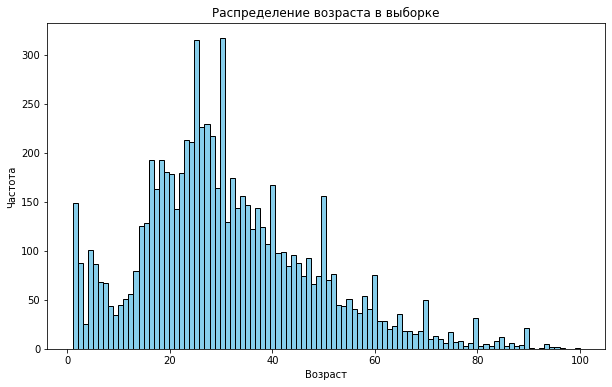

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [14]:
labels.groupby('real_age').count().sort_values(by='file_name', ascending=False).head(7)

,file_name
real_age,
30,317
25,315
27,229
26,226
28,217
23,213
24,211


Чаще других в датасете представлены люди в возрасте 25 и 30 лет. Так же наблюдаются всплески возраста каждые 10 лет - 40, 50, 60, 70, 80 и тд. Это может быть связано с не очень качественной разметкой данных - округление до юбилейного года. Среди наиболее частых - фотографии людей в возрасте с 23 по 30 лет.

In [7]:
sample_photoes = list(labels['file_name'].sample(25))

/tmp/ipykernel_31/3547225923.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


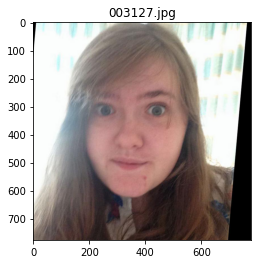

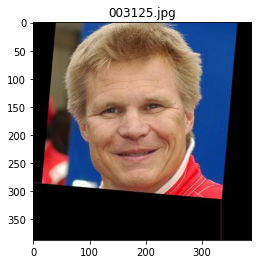

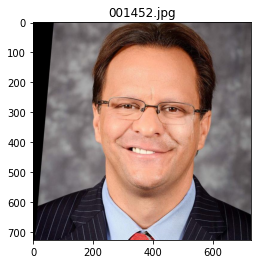

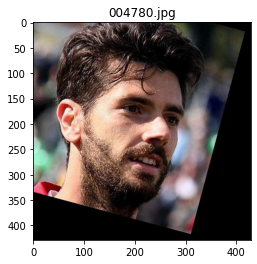

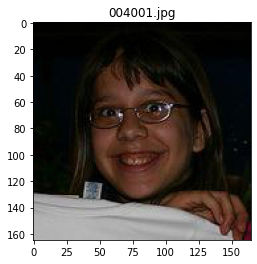

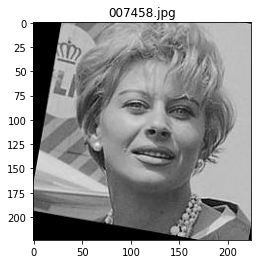

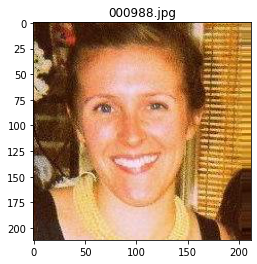

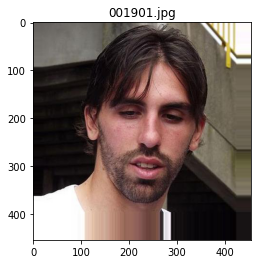

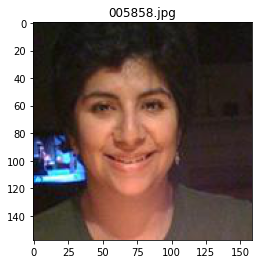

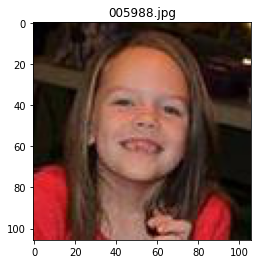

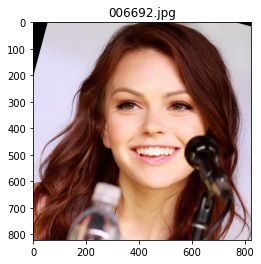

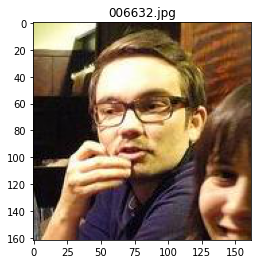

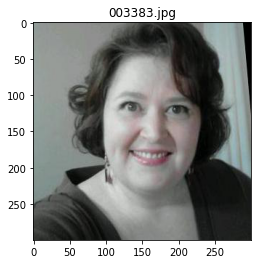

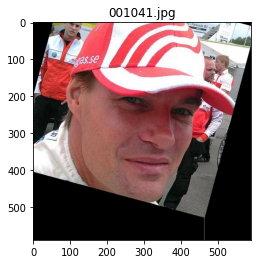

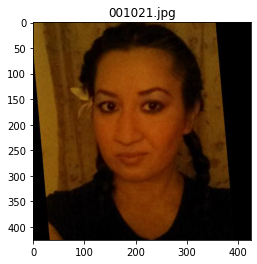

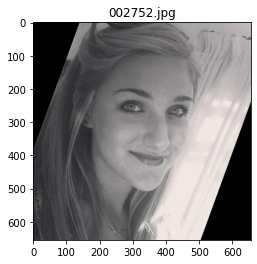

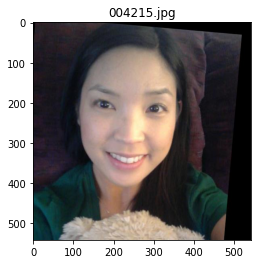

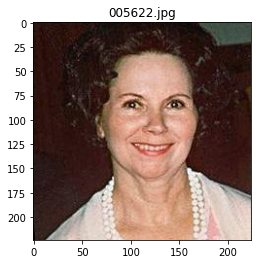

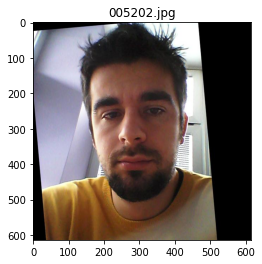

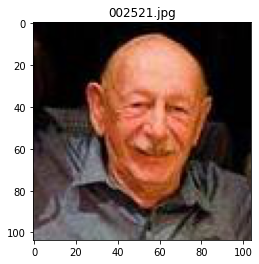

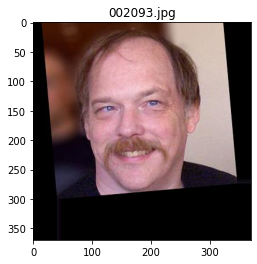

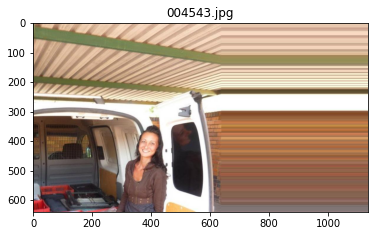

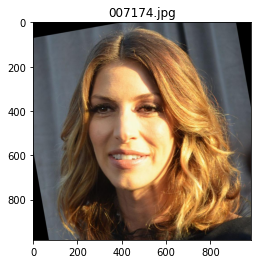

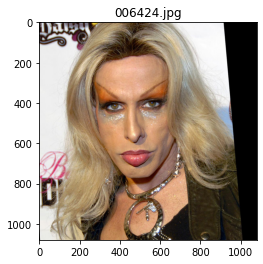

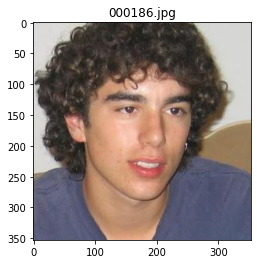

In [8]:
image_directory = '/datasets/faces/final_files/'

for photo in sample_photoes:
    img_path = image_directory + photo
    img = image.load_img(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(photo)

plt.show()

Всего в нашем датасете 7591 фото, причем они не однородны по своей сути - встречаются и черно-белые и цветные кадры, разного разрешения, есть повернутые изображения, которые отцентрированы так, чтобы лицо было расположено максимально вертикально, большая часть фото с лицами крупным планом.

Минимальный и максимальный возраст, где сконцентрирована большая часть фото - это с 14 до 40 лет. 
Предполагаю, что модель будет лучше предсказывать возраст для людей этого возрастного среза. А молодых (до 14 лет) и старше 40 лет будет предсказывать хуже.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [10]:
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        rotation_range = 10,
        shear_range = 0.1,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        seed=12)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```python
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-11-09 08:47:16.528609: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-09 08:47:18.253337: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 190.0732 - mae: 10.3162 - val_loss: 646.5494 - val_mae: 20.4977
Epoch 2/10
178/178 - 39s - loss: 101.2779 - mae: 7.6598 - val_loss: 317.3777 - val_mae: 13.2586
Epoch 3/10
178/178 - 39s - loss: 59.7985 - mae: 5.9320 - val_loss: 302.6397 - val_mae: 12.9675
Epoch 4/10
178/178 - 38s - loss: 39.2156 - mae: 4.8387 - val_loss: 162.6931 - val_mae: 9.6339
Epoch 5/10
178/178 - 38s - loss: 28.7219 - mae: 4.1207 - val_loss: 115.9169 - val_mae: 8.0401
Epoch 6/10
178/178 - 38s - loss: 22.5845 - mae: 3.6923 - val_loss: 81.0207 - val_mae: 6.8074
Epoch 7/10
178/178 - 40s - loss: 16.5690 - mae: 3.1160 - val_loss: 75.1744 - val_mae: 6.5262
Epoch 8/10
178/178 - 41s - loss: 12.2770 - mae: 2.6643 - val_loss: 86.3344 - val_mae: 7.0096
Epoch 9/10
178/178 - 41s - loss: 10.0001 - mae: 2.4068 - val_loss: 82.9332 - val_mae: 6.9272
Epoch 10/10
178/178 - 41s - loss: 10.0129 - mae: 2.4117 - val_loss: 73.1869 - val_mae: 6.3831
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 73.1869 - mae: 6.3831
```

## Анализ обученной модели

Проведен исследовательский анализ данных. Была использована нейронная сеть глубиной в 50 слоев ResNet.
Сеть была заново обучена на используемом наборе данных. Исходя из особенностей фотографий в датасете, а так же подобрав параметры применили аугментацию: горизонтальное отражение, поворот, наклон и смещение. 
В результате обучения сети на 10 эпохах MAE на тестовых данных равно 6.38, что является в целом хорошим результатом и меньше требуемого порога МАЕ = 8. 

По значениям МАЕ на обучающей выборке видно, что модель переобучена (MAE на обучающей выборке - 2.4), но степень переобучения не очень велика и этого достаточно для поставленной задачи.